# Informe nº7
    Notas: breve actualización del TFG. Propuesta de un método para estimar la radiación difusa por sectores.
    Fecha: 30/07/2020
   
   ### Estimación de la radiación difusa percibida en distintos sectores de cielo
    A continuación se expone un método para la estimación de la radiación difusa percibida en un sector del cielo, dado un ángulo sólido.

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime
!pip install sklearn
!pip install seaborn

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sn
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from datetime import timedelta
from glob import glob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

   ### Estimación de la radiación difusa percibida en distintos sectores de cielo
    Como hemos visto en informes anteriores, con el método basado en la integral de la luminancia de los píxeles no hemos obtenido buenos resultados, con lo que es necesaio definir un nuevo método mediante el cual poder estimar la radiación difusa percibida en distintos sectores del cielo.
    Hemos observado que la distinción en dos tipos de cielo es un aproximacion acertada a la hora de estimar la radiación percibida. Por este motivo, se ha decidido continuar con esta aproximación.

   #### Cieslo despejado
    Según los resulados expuestos en los anteriores informes, hemos visto que en este tipo de cielo las intensidad media de los píxeles que no corresponden a nubes presentan una correlación mayor con la radiación percibida. Además, consideraremos que la radiación percibida es isotrópiaca, es decir, la radiación percibida es uniforme en todo el cielo libre de nubes.
    Este método se basa en calcular el área de cielo libre de nubes que se encuentra en el ángulo sólido especificado y, a continuación, estimar la fracción a la que corresponde del área total de cielo libre de nubes. Esta relación, sería idéntica a la radiación percibida en ese ángulo sólido y la total estimada. 

In [2]:
# Correlación entre las medidas y la radiación difusa para cielos despejados
pd_info_regresion_despejado = pd.read_csv('Datos/info_regresion_despejado_completo.csv')

# Matrices de correlación
Corr_matrix = pd_info_regresion_despejado.corr()
correlacion_difusa = Corr_matrix[['Radiacion difusa']].drop(['ghi', 'Zenith', 'Azimuth', 'Área solar', 'Radiacion', 'Factor solar', 'Ratio nubes', 'Intensidad cielo', 'Unnamed: 0', 'Intensidad nubes'])


# Correlación entre las medidas y la radiación difusa para cielos nublados
correlacion_difusa[['Radiacion difusa']]

,Radiacion difusa
Radiacion difusa,1.000000
Intensidad cielo No ponderado Coseno:True Gamma_corr:True,0.146463
Intensidad cielo No ponderado Coseno:False Gamma_corr:True,0.074988
Intensidad cielo No ponderado Coseno:True Gamma_corr:False,0.145981
Intensidad cielo No ponderado Coseno:False Gamma_corr:False,0.053487
Intensidad cielo CCIR Coseno:True Gamma_corr:True,0.147038
Intensidad cielo CCIR Coseno:False Gamma_corr:True,0.082548
Intensidad cielo CCIR Coseno:True Gamma_corr:False,0.146318
Intensidad cielo CCIR Coseno:False Gamma_corr:False,0.052442
Intensidad cielo ITUR Coseno:True Gamma_corr:True,0.146714


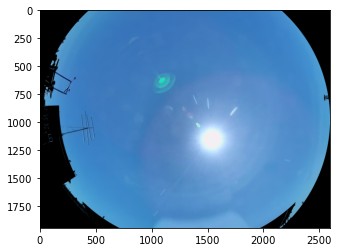

In [3]:
# Muestra de la imágen que utilizaremos como ejemplo
path_img_despejado = 'Fotos Cielo/imagen_original_2020-05-20-14h49min.jpg'
img_despejado = cv2.imread(path_img_despejado, cv2.IMREAD_COLOR)
img_despejado = pre_procesado(img_despejado)

muestra_imagen(img_despejado)

In [4]:
# Se muestra la mácara de cielo despejado
hora_img = hora_imagen(path_img_despejado)
res_sol = sol_cubierto(img_despejado, hora_img)

if res_sol != 0:
    factor_solar, centroide_img, area_solar, circularidad  = res_sol

print('Se ha observado un factor solar de {:.2f}.'.format(factor_solar))
print('Observamos que el centroide solar se encuentra en {}.'.format(centroide_img))
print('Con un área solar de {} pix2 y una circularidad de {:.2f}.'.format(area_solar, circularidad))

Se ha observado un factor solar de 1.00.
Observamos que el centroide solar se encuentra en (1539, 1153).
Con un área solar de 20740.5 pix2 y una circularidad de 0.81.


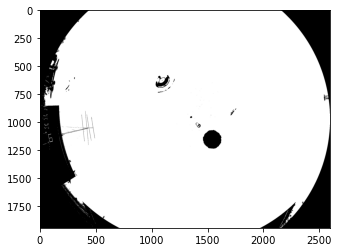

In [5]:
mask_nubes = mascara_nubes(img_despejado, centroide_img)
mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)

mask_sol = mascara_solar(img_despejado)
mask_no_sol = cv2.bitwise_not(mask_sol, mask=cielo)
mask_cielo = cv2.bitwise_and(mask_cielo, mask_no_sol, mask=cielo)

muestra_imagen(mask_cielo)

Excepto unos píxeles detectados por un error producido por la lente de la cámara, observamos que todos los píxeles correspondientes a cielo despejado se muestran en la máscara.

In [6]:
# Obtenemos la radiación difusa estimada
radiacion_medida = pd_info_regresion_despejado.set_index('Unnamed: 0.1').loc[hora_img.strftime('%Y-%m-%d %H:%M:%S')]['Radiacion']
ratio_nubes = porcion_nubes_cielo(mask_nubes)
intens_media = intensidad_media(img_despejado, mask=mask_cielo, coseno=True, gamma=2.2) / 255

rad_estimada = rad_difusa(radiacion_medida, ratio_nubes, factor_solar, intens_media, cielo='despejado')
print('La radiación difusa estimada es de {:.2f} W/m2'.format(rad_estimada))

C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:272: RuntimeWarning: divide by zero encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))
C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:272: RuntimeWarning: invalid value encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))


La radiación difusa estimada es de 77.37 W/m2


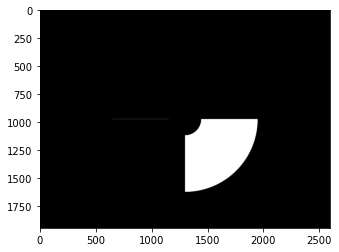

In [7]:
# Mostramos el ángulo sólido de ejemplo que deseamos obtener
# Método 1: Dado un rango de ángulos cenitales y azimutales
matriz_posicion = matriz_posiciones()
pixels_zeniths = matriz_posicion[:,:,0]
pixels_azimuths = matriz_posicion[:,:,1]

mask_Z = cv2.inRange(pixels_zeniths, 10, 45)
mask_A = cv2.inRange(pixels_azimuths, 180, 270)
mask_ang_sol = cv2.bitwise_and(mask_Z, mask_A)

muestra_imagen(mask_ang_sol)

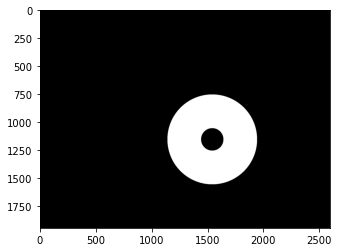

In [8]:
# Método 2: Dado una distancia a un punto de la imágen, en este caso centroide solar
matriz_distan_centroide = matriz_distancias(centroide_img)

mask_dist = cv2.inRange(matriz_distan_centroide, 100, 400)
muestra_imagen(mask_dist)

In [9]:
# Método 1
cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_ang_sol, mask=cielo))
cielo_despejado_total = cv2.countNonZero(mask_cielo)

ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total

print('En el ángulo sólido del método 1 observamos el {:.2f}% del cielo despejado total.'.format(ratio_cielo_despejado*100))
print('La radiación difusa estimada en este sector del cielo es de {:.2f} W/m2.'.format(ratio_cielo_despejado * rad_estimada))

En el ángulo sólido del método 1 observamos el 6.93% del cielo despejado total.
La radiación difusa estimada en este sector del cielo es de 5.36 W/m2.


In [10]:
# Método 2
cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_dist, mask=cielo))
cielo_despejado_total = cv2.countNonZero(mask_cielo)

ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total

print('En el ángulo sólido del método 2 observamos el {:.2f}% del cielo despejado total.'.format(ratio_cielo_despejado*100))
print('La radiación difusa estimada en este sector del cielo es de {:.2f} W/m2.'.format(ratio_cielo_despejado * rad_estimada))

En el ángulo sólido del método 2 observamos el 11.12% del cielo despejado total.
La radiación difusa estimada en este sector del cielo es de 8.60 W/m2.


   #### Cielos nublados
    De forma similar a los cielos despejado, en este tipo de cielos cacularesmos el porcentaje de nubes que se encuentra en el ángulo sólido definido. De forma similar, suponems que la radiación difusa porviene en mayor parte de las nubes y que esta se emite de forma isotrópica en las distintas nubes.

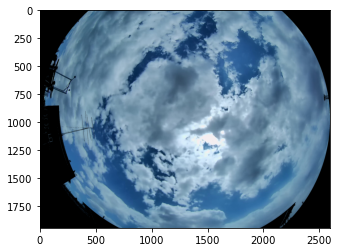

In [11]:
# Muestra de la imágen que utilizaremos como ejemplo
path_img_nublado = 'Fotos Cielo/imagen_original_2020-06-08-14h56min.jpg'
img_nublado = cv2.imread(path_img_nublado, cv2.IMREAD_COLOR)
img_nublado = pre_procesado(img_nublado)

muestra_imagen(img_nublado)

In [12]:
# Se muestra la mácara de cielo nublado
hora_img = hora_imagen(path_img_nublado)
res_sol = sol_cubierto(img_nublado, hora_img)

if res_sol != 0:
    factor_solar, centroide_img, area_solar, circularidad  = res_sol

    print('Se ha observado un factor solar de {:.2f}.'.format(factor_solar))
    print('Observamos que el centroide solar se encuentra en {}.'.format(centroide_img))
    print('Con un área solar de {} pix2 y una circularidad de {:.2f}.'.format(area_solar, circularidad))

else:
    factor_solar = res_sol
    
    print('Se ha observado un factor solar de {:.2f}.'.format(factor_solar))

Se ha observado un factor solar de 0.00.


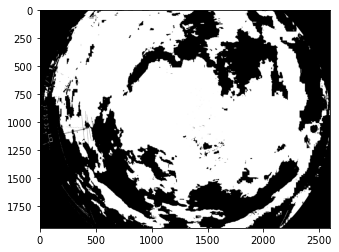

In [13]:
mask_nubes = mascara_nubes(img_nublado)
muestra_imagen(mask_nubes)

In [14]:
# Obtenemos la radiación difusa estimada
ghi = rad_gh_teorica(hora_img)
ratio_nubes = porcion_nubes_cielo(mask_nubes)
intens_media = intensidad_media(img_nublado, mask_nubes, gamma=2.2) / 255

rad_estimada = rad_difusa(ghi, ratio_nubes, factor_solar, intens_media, cielo='nublado')
print('La radiación difusa estimada es de {:.2f} W/m2'.format(rad_estimada))

La radiación difusa estimada es de 272.90 W/m2


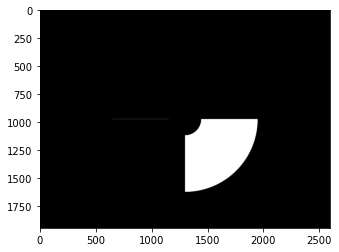

In [15]:
# Mostramos el ángulo sólido de ejemplo que deseamos obtener
# Método 1: Dado un rango de ángulos cenitales y azimutales
matriz_posicion = matriz_posiciones()
pixels_zeniths = matriz_posicion[:,:,0]
pixels_azimuths = matriz_posicion[:,:,1]

mask_Z = cv2.inRange(pixels_zeniths, 10, 45)
mask_A = cv2.inRange(pixels_azimuths, 180, 270)
mask_ang_sol = cv2.bitwise_and(mask_Z, mask_A)

muestra_imagen(mask_ang_sol)

In [16]:
# Método 1
cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_ang_sol, mask=cielo))
cielo_despejado_total = cv2.countNonZero(mask_cielo)

ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total

print('En el ángulo sólido del método 1 observamos el {:.2f}% del cielo despejado total.'.format(ratio_cielo_despejado*100))
print('La radiación difusa estimada en este sector del cielo es de {:.2f} W/m2.'.format(ratio_cielo_despejado * rad_estimada))

En el ángulo sólido del método 1 observamos el 6.93% del cielo despejado total.
La radiación difusa estimada en este sector del cielo es de 18.92 W/m2.


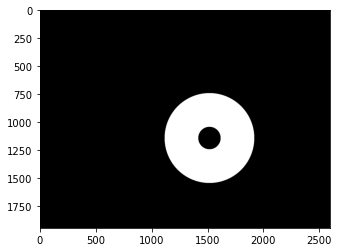

In [17]:
# Método 2: Dado una distancia a un punto de la imágen, en este caso centroide solar
centroide_teorico = centroide_solar(hora_img, imagen=True)

matriz_distan_centroide = matriz_distancias(centroide_teorico)

mask_dist = cv2.inRange(matriz_distan_centroide, 100, 400)
muestra_imagen(mask_dist)

In [18]:
# Método 2
cielo_ang_sol = cv2.countNonZero(cv2.bitwise_and(mask_cielo, mask_dist, mask=cielo))
cielo_despejado_total = cv2.countNonZero(mask_cielo)

ratio_cielo_despejado = cielo_ang_sol / cielo_despejado_total

print('En el ángulo sólido del método 2 observamos el {:.2f}% del cielo despejado total.'.format(ratio_cielo_despejado*100))
print('La radiación difusa estimada en este sector del cielo es de {:.2f} W/m2.'.format(ratio_cielo_despejado * rad_estimada))

En el ángulo sólido del método 2 observamos el 11.10% del cielo despejado total.
La radiación difusa estimada en este sector del cielo es de 30.28 W/m2.


### Bonus: Dibujo del camino teórico del sol en la imágen

In [19]:
def dibujo_camino_sol(img_bgr, hora_img, delta_=timedelta(hours=2), color_=(0,255,0)):
    # Se preoaran las variables auxiliares
    img_bgr_copy = img_bgr.copy()
    lista_horas = []
    delta = timedelta(minutes=5)
    dia_img = hora_img.date()
    
    # Se obtiene las horas de puesta y salida del sol en el día de la toma de la imágen
    hora_salida_sol, hora_puesta_sol = salida_puesta_sol(dia_img)
    hora = hora_salida_sol + delta_
    
    # Se obtiene una lista con las instantes en los que dibujar los centroides solares
    while hora < hora_puesta_sol - delta_:
        hora += delta
        lista_horas.append(hora)
    
    # Se recorre la lista de horas, dibujando en la imñagen el centroide solar en ese instante
    for hora in lista_horas:
        centroide_img = centroide_solar(hora, imagen=True)
        cv2.circle(img_bgr_copy, centroide_img, 2, color=color_, thickness=20)
        
        
    return img_bgr_copy

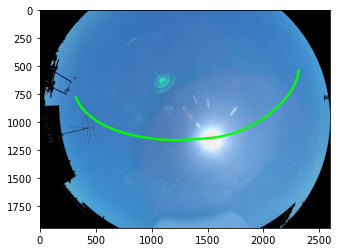

In [20]:
img_camino_sol = dibujo_camino_sol(img_despejado, hora_img)

muestra_imagen(img_camino_sol)

   ### Comentarios 
    Este no es un método basado en ningún principio científico, pero debido a que las pruebas para obtener una relación directa entre luminancia de los píxeles y la radiación percibida no han sido satisfactorias, se propone este método, que de alguna forma permite estimar la radiaciñon percibida en un ángulo sólido determinado.